# Score biweekly ML forecasts against re-calibrated ECWMF forecast with RPSS

Goal:

- Score biweekly 2020 ML-based forecasts against climatology with RPSS
- identical to scorer bot script: https://renkulab.io/gitlab/tasko.olevski/s2s-ai-competition-scoring-image/-/blob/master/scoring/scoring_script.py
- (for reference) RPSS of recalibrated real-time 2020 ECMWF forecasts

Requirements:

- [`xskillscore`](https://github.com/xarray-contrib/xskillscore)
- [renku datasets](https://renku-python.readthedocs.io/en/latest/commands.html#module-renku.cli.dataset) / file
    - observations
        - probabilistic:
            - renku dataset: `forecast-like-observations_2020_biweekly_terciled.nc`
    - ML forecasts
        - probabilistic:
            - file: `../submissions/ML_prediction_2020.nc`
    - benchmark to check whether ML better than recalibrated ECMWF:
        - probabilistic:
            - renku dataset: `ecmwf_recalibrated_benchmark_2020_biweekly_terciled.nc` 
        
Output:
- RPSS score spatially averaged from [90N-60S] and averaged over both `lead_time`s and variables

In [1]:
import xarray as xr
import xskillscore as xs
import numpy as np

xr.set_options(keep_attrs=True)
xr.set_options(display_style='text')

cache_path = "../data"

plot = False # take much more space in git, consider not commiting figures regularly because git size will increase

/opt/conda/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


# Get categorized

## 2020 observations

In [2]:
# to use retrieve from git lfs
!renku storage pull ../data/forecast-like-observations_2020_biweekly_terciled.nc

In [3]:
obs_p = xr.open_dataset(f'{cache_path}/forecast-like-observations_2020_biweekly_terciled.nc')

obs_p.sizes

/opt/conda/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
/opt/conda/lib/python3.8/site-packages/gribapi/_bindings.cpython-38-x86_64-linux-gnu.so: undefined symbol: codes_bufr_key_is_header
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Frozen(SortedKeysDict({'category': 3, 'lead_time': 2, 'forecast_time': 53, 'latitude': 121, 'longitude': 240}))

## 2020 ML-based forecasts

In [4]:
!renku storage pull ../submissions/ML_prediction_2020.nc

In [5]:
# submission for your ML model
fct_p = xr.open_dataset(f"../submissions/ML_prediction_2020.nc")
fct_p.sizes

Frozen(SortedKeysDict({'forecast_time': 53, 'latitude': 121, 'lead_time': 2, 'longitude': 240, 'category': 3}))

## climatology

In [6]:
clim_p = xr.DataArray([1/3, 1/3, 1/3], dims='category', coords={'category':['below normal', 'near normal', 'above normal']}).to_dataset(name='tp')
clim_p['t2m'] = clim_p['tp']

### checks

In [7]:
from scripts import assert_predictions_2020

In [8]:
assert_predictions_2020(fct_p)
assert_predictions_2020(obs_p)

# RPS

## RPS ML model

In [9]:
rps_ML = xs.rps(obs_p, fct_p, category_edges=None, dim='forecast_time', input_distributions='p').compute()

In [10]:
if plot:
    for v in rps_ML.data_vars:
        rps_ML[v].plot(robust=True, col='lead_time')

## RPS climatology

In [11]:
rps_clim = xs.rps(obs_p, clim_p, category_edges=None, dim='forecast_time', input_distributions='p').compute()

In [12]:
if plot:
    for v in rps_clim.data_vars:
        rps_clim[v].plot(robust=True, col='lead_time')

## RPSS

In [13]:
rpss = (1 - rps_ML / rps_clim)

In [14]:
if plot:
    for v in rpss.data_vars:
        rpss[v].plot(robust=True, col='lead_time')

# Scoring for RPSS leaderboard

In [15]:
# check for -inf grid cells
if (rpss==-np.inf).to_array().any():
    print(f'find N={(rpss == rpss.min()).sum()} -inf grid cells')

    # dirty fix
    rpss = rpss.clip(-1, 1)

In [16]:
# what to do with requested grid cells where NaN is submitted? also penalize, todo: https://renkulab.io/gitlab/aaron.spring/s2s-ai-challenge-template/-/issues/7

In [17]:
# for the subleaderboards
mask = xr.ones_like(rpss.isel(lead_time=0, drop=True)).reset_coords(drop=True).t2m
boundary_tropics = 30
mask = xr.concat([mask.where(mask.latitude > boundary_tropics),
                mask.where(np.abs(mask.latitude) <= boundary_tropics),
                mask.where((mask.latitude < -boundary_tropics) & (mask.latitude > -60))],'area')
mask = mask.assign_coords(area=['northern_extratropics', 'tropics', 'southern_extratropics'])
mask.name = 'area'

mask = mask.where(rpss.t2m.isel(lead_time=0, drop=True).notnull())

In [18]:
# weighted area mean
weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
# spatially weighted score averaged and averaged over lead_times
scores = (rpss*mask).weighted(weights).mean('latitude').mean('longitude')
pd_scores = scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)

pd_scores # for subleaderboards

lead_time                  14 days  28 days
    area                                   
t2m northern_extratropics     0.06     0.02
    tropics                   0.08     0.06
    southern_extratropics     0.03    -0.01
tp  northern_extratropics    -0.03    -0.04
    tropics                   0.35     0.33
    southern_extratropics    -0.04    -0.06

In [19]:
# averaged variables to one single value
scores = rpss.sel(latitude=slice(None, -60)).weighted(weights).mean('latitude').mean('longitude').to_array().mean(['lead_time','variable']).reset_coords(drop=True)
# final score score transfered to leaderboard
print(scores)

<xarray.DataArray ()>
array(0.06269967)


In [20]:
# check your submission status here: https://renkulab.io/gitlab/tasko.olevski/s2s-ai-competition-scoring-image/-/blob/master/README.md

# RPS re-calibrated ECMWF benchmark
for reference to check what the ML-model should beat

In [21]:
plot = True # show ECMWF RPSS for reference

In [20]:
!renku storage pull ../data/ecmwf_recalibrated_benchmark_2020_biweekly_terciled.nc

In [21]:
bench_p = xr.open_dataset('../data/ecmwf_recalibrated_benchmark_2020_biweekly_terciled.nc')
bench_p.sizes

Frozen(SortedKeysDict({'forecast_time': 53, 'category': 3, 'lead_time': 2, 'latitude': 121, 'longitude': 240}))

In [22]:
assert_predictions_2020(bench_p)

In [23]:
rps_bench = xs.rps(obs_p, bench_p, category_edges=None, dim='forecast_time', input_distributions='p').compute()

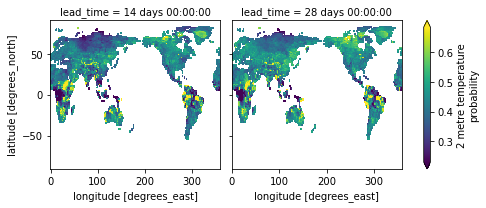

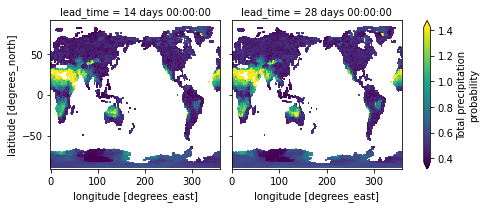

In [26]:
if plot:
    for v in rps_bench.data_vars:
        rps_bench[v].plot(robust=True, col='lead_time')

In [24]:
rpss_bench = (1 - rps_bench / rps_clim)

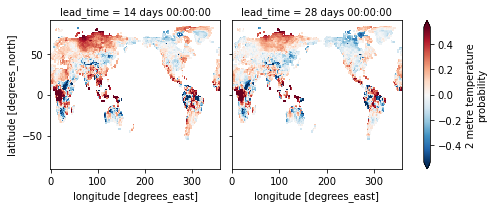

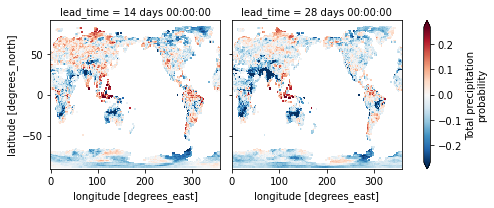

In [28]:
if plot:
    for v in rpss_bench.data_vars:
        rpss_bench[v].plot(robust=True, col='lead_time')

In [25]:
scores_bench = (rpss_bench*mask).weighted(weights).mean('latitude').mean('longitude')
pd_scores_bench = scores_bench.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)

pd_scores_bench # for subleaderboards

lead_time                  14 days  28 days
    area                                   
t2m northern_extratropics     0.04    -0.00
    tropics                   0.07     0.05
    southern_extratropics     0.01    -0.03
tp  northern_extratropics    -0.02    -0.03
    tropics                  -0.03    -0.09
    southern_extratropics    -0.01    -0.01

In [26]:
# averaged variables to one single value
scores_bench = rpss_bench.sel(latitude=slice(None, -60)).weighted(weights).mean('latitude').mean('longitude').to_array().mean(['lead_time','variable']).reset_coords(drop=True)
# final score score transfered to leaderboard
print(scores_bench)

<xarray.DataArray ()>
array(-0.00701943)
